In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Research Questions to be addressed:

* - How can the data be used to predict weather conditions throughout the world?
* - How do the variables relate to each other?
* - Which variables have a greater effect on the climate variations?
* - Does the amount of movement of the buoy effect the reliability of the data?
* - When performing an analysis of the data, one should pay attention the possible affect of autocorrelation. Using a multiple regression approach to model the data would require a look at autoregression since the weather statistics of the previous days will affect today's weather.

# Importing Libraries and Reading the dataset


In [2]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 128 kB/s eta 0:00:013
     |████████████████████████████████| 198 kB 6.0 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853646 sha256=58cf8da598fd4f4992195ed34b689c03ea15d6868cc65b21abaa13af1b79796b
  Stored in directory: /Users/bhanukiran/Library/Caches/pip/wheels/58/94/83/915c9059e4b038e2d43a6058f307fe1c3e8536e5745f3b23b7
Successfully built pyspark


In [3]:
# libraries
import dask
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#datasets
df = pd.read_csv('elnino.csv')

In [5]:
df.head()

,Observation,Year,Month,Day,Date,Latitude,Longitude,Zonal Winds,Meridional Winds,Humidity,Air Temp,Sea Surface Temp
0,1,80,3,7,800307,-0.02,-109.46,-6.8,0.7,.,26.14,26.24
1,2,80,3,8,800308,-0.02,-109.46,-4.9,1.1,.,25.66,25.97
2,3,80,3,9,800309,-0.02,-109.46,-4.5,2.2,.,25.69,25.28
3,4,80,3,10,800310,-0.02,-109.46,-3.8,1.9,.,25.57,24.31
4,5,80,3,11,800311,-0.02,-109.46,-4.2,1.5,.,25.3,23.19


In [6]:
df.shape[0]

178080

# Exploratory Data Analysis

In [7]:
df.describe()

,Observation,Year,Month,Day,Date,Latitude,Longitude
count,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000
mean,89040.500000,93.302325,6.504869,15.720536,933689.455374,0.473626,-54.025233
std,51407.412306,3.393818,3.459657,8.800487,33900.474320,4.583041,135.363994
min,1.000000,80.000000,1.000000,1.000000,800307.000000,-8.810000,-180.000000
25%,44520.750000,92.000000,4.000000,8.000000,920116.000000,-2.010000,-154.950000
50%,89040.500000,94.000000,6.000000,16.000000,940601.000000,0.010000,-111.260000
75%,133560.250000,96.000000,10.000000,23.000000,960617.000000,4.980000,147.010000
max,178080.000000,98.000000,12.000000,31.000000,980623.000000,9.050000,171.080000


The summary of the observation column is redundant. Soon we may drop this column when performing ML.  
* The count of all the columns are the same - 178080.  
* Year min and max seem alright because the data is crom 1980-1998. 
* Month min and max seem alright, same goes for Day.  
* The date column has to be look at, cannot understand what the date format is yet.  
* Even though the other columns are conists of numbers, from running the head function *df.head()* we can see there are missing values represented as " . " The data type might not be numeric of these columns.



In [8]:
# make all column names lower and remove any whitespaces
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()

In [9]:
#running the dtypes function to check the dataframe structure.
df.dtypes

observation           int64
year                  int64
month                 int64
day                   int64
date                  int64
latitude            float64
longitude           float64
zonal winds          object
meridional winds     object
humidity             object
air temp             object
sea surface temp     object
dtype: object

* We can see that the last 5 columns are of type objects, and therefore they didnt show up when the describe function was run.  
* But these columns have null values expressed as " . "  
* We can fix this in many ways. Let's start by making the " . " values into null values.


### to replace the " . " values in dataframe  

* Since we have a lot of rows in the dataset, to run through each element in each column, match it and changing the value is time consuming.
* Hence we use PySpark functionality to make the process faster. OR we can use dask

In [10]:
# try fixing with pyspark or dask
for i in df.columns:
    df[i] = df[i].replace('.', np.nan)

In [11]:
df.dtypes

observation           int64
year                  int64
month                 int64
day                   int64
date                  int64
latitude            float64
longitude           float64
zonal winds          object
meridional winds     object
humidity             object
air temp             object
sea surface temp     object
dtype: object

Now we can change the data type of objects to numeric 

In [12]:
df.columns


Index(['observation', 'year', 'month', 'day', 'date', 'latitude', 'longitude',
       'zonal winds', 'meridional winds', 'humidity', 'air temp',
       'sea surface temp'],
      dtype='object')

In [13]:
df[['zonal winds', 'meridional winds', 'humidity', 'air temp',
       'sea surface temp']] = df[['zonal winds', 'meridional winds', 'humidity', 'air temp',
       'sea surface temp']].apply(pd.to_numeric)

In [14]:
df.dtypes

observation           int64
year                  int64
month                 int64
day                   int64
date                  int64
latitude            float64
longitude           float64
zonal winds         float64
meridional winds    float64
humidity            float64
air temp            float64
sea surface temp    float64
dtype: object

# Dealing with null values

In [15]:
df.isna().sum()

observation             0
year                    0
month                   0
day                     0
date                    0
latitude                0
longitude               0
zonal winds         25163
meridional winds    25162
humidity            65761
air temp            18237
sea surface temp    17007
dtype: int64

In [16]:
df.describe()

,observation,year,month,day,date,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp
count,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,152917.000000,152918.000000,112319.000000,159843.000000,161073.000000
mean,89040.500000,93.302325,6.504869,15.720536,933689.455374,0.473626,-54.025233,-3.304772,0.249762,81.236525,26.887567,27.715309
std,51407.412306,3.393818,3.459657,8.800487,33900.474320,4.583041,135.363994,3.373492,2.999202,5.313061,1.816429,2.057428
min,1.000000,80.000000,1.000000,1.000000,800307.000000,-8.810000,-180.000000,-12.400000,-11.600000,45.400000,17.050000,17.350000
25%,44520.750000,92.000000,4.000000,8.000000,920116.000000,-2.010000,-154.950000,-5.800000,-1.700000,77.700000,26.060000,26.770000
50%,89040.500000,94.000000,6.000000,16.000000,940601.000000,0.010000,-111.260000,-4.000000,0.300000,81.200000,27.340000,28.290000
75%,133560.250000,96.000000,10.000000,23.000000,960617.000000,4.980000,147.010000,-1.400000,2.300000,84.800000,28.180000,29.230000
max,178080.000000,98.000000,12.000000,31.000000,980623.000000,9.050000,171.080000,14.300000,13.000000,99.900000,31.660000,31.260000


## Fixing missing values


In weather data, the weather is mostly consistent over weeks. It is a corner case that the weather changes drastically over night. With this in mind, we can actually impute data based on the values we have for each column.

* If there are multiple missing values, they would be the same.
* replacing with previosu values works best if the missing values are spread out
* for columns with missing values that are spread out, we can try to replace with previous values.

As we can see about 60% of the Humidity row is missing. And about 25k on zonal winds and meridional winds and about 18k in air tem and sea surface temp.

Although we can fix it with normal methods, by imputing with mean, understand the type of missingness would help us make a better decision at this point

* Missing completely at random (MCAR). When data are MCAR, the fact that the data are missing is independent of the observed and unobserved data.
* Missing at random (MAR). When data are MAR, the fact that the data are missing is systematically related to the observed but not the unobserved data.
* Missing not at random (MNAR). When data are MNAR, the fact that the data are missing is systematically related to the unobserved data, that is, the missingness is related to events or factors which are not measured by the researcher.

It is understandable for humidity to be missing, because of the fact that during some days, there might no be any humidity. But missing values in winds, air-temp, sea-surf-temp do not make sense. 

Let's drop rows with null values and check how much of data we have left.

In [17]:
df_no_null = df.dropna()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   observation       178080 non-null  int64  
 1   year              178080 non-null  int64  
 2   month             178080 non-null  int64  
 3   day               178080 non-null  int64  
 4   date              178080 non-null  int64  
 5   latitude          178080 non-null  float64
 6   longitude         178080 non-null  float64
 7   zonal winds       152917 non-null  float64
 8   meridional winds  152918 non-null  float64
 9   humidity          112319 non-null  float64
 10  air temp          159843 non-null  float64
 11  sea surface temp  161073 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 16.3 MB


In [19]:
df_no_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93935 entries, 4059 to 178078
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation       93935 non-null  int64  
 1   year              93935 non-null  int64  
 2   month             93935 non-null  int64  
 3   day               93935 non-null  int64  
 4   date              93935 non-null  int64  
 5   latitude          93935 non-null  float64
 6   longitude         93935 non-null  float64
 7   zonal winds       93935 non-null  float64
 8   meridional winds  93935 non-null  float64
 9   humidity          93935 non-null  float64
 10  air temp          93935 non-null  float64
 11  sea surface temp  93935 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 9.3 MB


We lose a lot of data! Hence dropping all the null rows does not make sense. We lose too much data

Let's fill air temp and sea surface temp with average values, since they have the least number of missing values

Let's subset the df so we don't lose our original data

In [20]:
df.head()

,observation,year,month,day,date,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp
0,1,80,3,7,800307,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24
1,2,80,3,8,800308,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97
2,3,80,3,9,800309,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28
3,4,80,3,10,800310,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31
4,5,80,3,11,800311,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19


In [21]:
df_clean = df

In [22]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   observation       178080 non-null  int64  
 1   year              178080 non-null  int64  
 2   month             178080 non-null  int64  
 3   day               178080 non-null  int64  
 4   date              178080 non-null  int64  
 5   latitude          178080 non-null  float64
 6   longitude         178080 non-null  float64
 7   zonal winds       152917 non-null  float64
 8   meridional winds  152918 non-null  float64
 9   humidity          112319 non-null  float64
 10  air temp          159843 non-null  float64
 11  sea surface temp  161073 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 16.3 MB


In [23]:
missing_total = df_clean.isnull().sum().sort_values(ascending=False)
percent = ((missing_total*100)/(df_clean.isnull().count())).sort_values(ascending=False)
percent

humidity            36.927785
zonal winds         14.130166
meridional winds    14.129605
air temp            10.240903
sea surface temp     9.550202
date                 0.000000
day                  0.000000
latitude             0.000000
longitude            0.000000
month                0.000000
observation          0.000000
year                 0.000000
dtype: float64

* calculate percentage of missing values and then you can display it directly
* more than 15% data is missing -> drop column
* otherwise try to fix it

In [24]:
df_clean['air temp'] = df_clean['air temp'].fillna(value=df_clean['air temp'].mean())
df_clean['sea surface temp'] = df_clean['sea surface temp'].fillna(value=df_clean['sea surface temp'].mean())

In [25]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   observation       178080 non-null  int64  
 1   year              178080 non-null  int64  
 2   month             178080 non-null  int64  
 3   day               178080 non-null  int64  
 4   date              178080 non-null  int64  
 5   latitude          178080 non-null  float64
 6   longitude         178080 non-null  float64
 7   zonal winds       152917 non-null  float64
 8   meridional winds  152918 non-null  float64
 9   humidity          112319 non-null  float64
 10  air temp          178080 non-null  float64
 11  sea surface temp  178080 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 16.3 MB


In [26]:
df_clean.describe()

,observation,year,month,day,date,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp
count,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,152917.000000,152918.000000,112319.000000,178080.000000,178080.000000
mean,89040.500000,93.302325,6.504869,15.720536,933689.455374,0.473626,-54.025233,-3.304772,0.249762,81.236525,26.887567,27.715309
std,51407.412306,3.393818,3.459657,8.800487,33900.474320,4.583041,135.363994,3.373492,2.999202,5.313061,1.720908,1.956718
min,1.000000,80.000000,1.000000,1.000000,800307.000000,-8.810000,-180.000000,-12.400000,-11.600000,45.400000,17.050000,17.350000
25%,44520.750000,92.000000,4.000000,8.000000,920116.000000,-2.010000,-154.950000,-5.800000,-1.700000,77.700000,26.270000,26.990000
50%,89040.500000,94.000000,6.000000,16.000000,940601.000000,0.010000,-111.260000,-4.000000,0.300000,81.200000,27.120000,28.030000
75%,133560.250000,96.000000,10.000000,23.000000,960617.000000,4.980000,147.010000,-1.400000,2.300000,84.800000,28.080000,29.150000
max,178080.000000,98.000000,12.000000,31.000000,980623.000000,9.050000,171.080000,14.300000,13.000000,99.900000,31.660000,31.260000


In [27]:
df.describe()

,observation,year,month,day,date,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp
count,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,152917.000000,152918.000000,112319.000000,178080.000000,178080.000000
mean,89040.500000,93.302325,6.504869,15.720536,933689.455374,0.473626,-54.025233,-3.304772,0.249762,81.236525,26.887567,27.715309
std,51407.412306,3.393818,3.459657,8.800487,33900.474320,4.583041,135.363994,3.373492,2.999202,5.313061,1.720908,1.956718
min,1.000000,80.000000,1.000000,1.000000,800307.000000,-8.810000,-180.000000,-12.400000,-11.600000,45.400000,17.050000,17.350000
25%,44520.750000,92.000000,4.000000,8.000000,920116.000000,-2.010000,-154.950000,-5.800000,-1.700000,77.700000,26.270000,26.990000
50%,89040.500000,94.000000,6.000000,16.000000,940601.000000,0.010000,-111.260000,-4.000000,0.300000,81.200000,27.120000,28.030000
75%,133560.250000,96.000000,10.000000,23.000000,960617.000000,4.980000,147.010000,-1.400000,2.300000,84.800000,28.080000,29.150000
max,178080.000000,98.000000,12.000000,31.000000,980623.000000,9.050000,171.080000,14.300000,13.000000,99.900000,31.660000,31.260000


As we can compare from the above tables. the statistics did not change after replacing the missing values with mean. 

In [28]:
df_clean.isna().sum()

observation             0
year                    0
month                   0
day                     0
date                    0
latitude                0
longitude               0
zonal winds         25163
meridional winds    25162
humidity            65761
air temp                0
sea surface temp        0
dtype: int64

Filling in missing values with previous values for the winds column might not be the best idea. Because if the missing values are continous, the all the 25k rows will have the same values

### Trying sci-kit learn imputers

In [29]:
import sklearn.impute
from sklearn import impute
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

* most frequent only checks the column? Yes
* fix: Use group by and fix according to the group mean of the rows.

In [30]:
df_clean[['zonal winds','meridional winds']]=imp.fit_transform(df_clean[['zonal winds','meridional winds']])

In [31]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   observation       178080 non-null  int64  
 1   year              178080 non-null  int64  
 2   month             178080 non-null  int64  
 3   day               178080 non-null  int64  
 4   date              178080 non-null  int64  
 5   latitude          178080 non-null  float64
 6   longitude         178080 non-null  float64
 7   zonal winds       178080 non-null  float64
 8   meridional winds  178080 non-null  float64
 9   humidity          112319 non-null  float64
 10  air temp          178080 non-null  float64
 11  sea surface temp  178080 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 16.3 MB


In [32]:
df_clean.describe()

,observation,year,month,day,date,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp
count,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,112319.000000,178080.000000,178080.000000
mean,89040.500000,93.302325,6.504869,15.720536,933689.455374,0.473626,-54.025233,-3.572571,0.186212,81.236525,26.887567,27.715309
std,51407.412306,3.393818,3.459657,8.800487,33900.474320,4.583041,135.363994,3.195025,2.783660,5.313061,1.720908,1.956718
min,1.000000,80.000000,1.000000,1.000000,800307.000000,-8.810000,-180.000000,-12.400000,-11.600000,45.400000,17.050000,17.350000
25%,44520.750000,92.000000,4.000000,8.000000,920116.000000,-2.010000,-154.950000,-5.500000,-1.400000,77.700000,26.270000,26.990000
50%,89040.500000,94.000000,6.000000,16.000000,940601.000000,0.010000,-111.260000,-4.600000,-0.200000,81.200000,27.120000,28.030000
75%,133560.250000,96.000000,10.000000,23.000000,960617.000000,4.980000,147.010000,-2.000000,1.900000,84.800000,28.080000,29.150000
max,178080.000000,98.000000,12.000000,31.000000,980623.000000,9.050000,171.080000,14.300000,13.000000,99.900000,31.660000,31.260000


In [33]:
df.describe()

,observation,year,month,day,date,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp
count,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,178080.000000,112319.000000,178080.000000,178080.000000
mean,89040.500000,93.302325,6.504869,15.720536,933689.455374,0.473626,-54.025233,-3.572571,0.186212,81.236525,26.887567,27.715309
std,51407.412306,3.393818,3.459657,8.800487,33900.474320,4.583041,135.363994,3.195025,2.783660,5.313061,1.720908,1.956718
min,1.000000,80.000000,1.000000,1.000000,800307.000000,-8.810000,-180.000000,-12.400000,-11.600000,45.400000,17.050000,17.350000
25%,44520.750000,92.000000,4.000000,8.000000,920116.000000,-2.010000,-154.950000,-5.500000,-1.400000,77.700000,26.270000,26.990000
50%,89040.500000,94.000000,6.000000,16.000000,940601.000000,0.010000,-111.260000,-4.600000,-0.200000,81.200000,27.120000,28.030000
75%,133560.250000,96.000000,10.000000,23.000000,960617.000000,4.980000,147.010000,-2.000000,1.900000,84.800000,28.080000,29.150000
max,178080.000000,98.000000,12.000000,31.000000,980623.000000,9.050000,171.080000,14.300000,13.000000,99.900000,31.660000,31.260000


In [34]:
df_clean.isna().sum()

observation             0
year                    0
month                   0
day                     0
date                    0
latitude                0
longitude               0
zonal winds             0
meridional winds        0
humidity            65761
air temp                0
sea surface temp        0
dtype: int64

Only humidity column is left. This has a lot of missing values. While 0 humidity is theoritically possible. A single water molecule makes it not zero. And considerting thhe buoys placed in the oceans. we cannot change all the 65k rows to 0

For now we can make a new dataframe and drop the humidity column. this way we retain most of the data solumns as well.

In [35]:
df_drop_humidity = df_clean.dropna()

In [36]:
df_drop_humidity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112319 entries, 4059 to 178078
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   observation       112319 non-null  int64  
 1   year              112319 non-null  int64  
 2   month             112319 non-null  int64  
 3   day               112319 non-null  int64  
 4   date              112319 non-null  int64  
 5   latitude          112319 non-null  float64
 6   longitude         112319 non-null  float64
 7   zonal winds       112319 non-null  float64
 8   meridional winds  112319 non-null  float64
 9   humidity          112319 non-null  float64
 10  air temp          112319 non-null  float64
 11  sea surface temp  112319 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 11.1 MB


## Data Visualisation

Now that the data is clean, let us start exploring the data so we know how they relate and what's actually happening so that we uncover insights

To understand the visualisation better, we add a few calculates columns such as Oceans and Hemisphere

* - How do the variables relate to each other?
* - Which variables have a greater effect on the climate variations?
* - Does the amount of movement of the buoy effect the reliability of the data?

In [37]:
### Oceans
df_drop_humidity['ocean'] = df_drop_humidity['longitude'] < 0.0
df_drop_humidity['ocean'].replace([True,False],['Pacific','Indian'],inplace= True)
### Hemisphere
df_drop_humidity['hemisphere'] = df_drop_humidity['latitude'] < 0.0
df_drop_humidity['hemisphere'].replace([True,False],['South','North'],inplace=True)

<ipython-input-37-e1dc20d841f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_humidity['ocean'] = df_drop_humidity['longitude'] < 0.0
/Users/bhanukiran/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-37-e1dc20d841f7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [38]:
df_drop_humidity.head()

,observation,year,month,day,date,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp,ocean,hemisphere
4059,4060,93,5,9,930509,-0.02,-109.96,-2.1,2.1,81.2,26.80,27.02,Pacific,South
4060,4061,93,5,10,930510,-0.02,-109.96,-3.4,1.4,84.2,26.95,26.91,Pacific,South
4061,4062,93,5,11,930511,-0.02,-109.96,-3.8,2.2,84.9,26.98,26.78,Pacific,South
4062,4063,93,5,12,930512,-0.02,-109.96,-3.0,1.5,86.9,26.93,26.74,Pacific,South
4063,4064,93,5,13,930513,-0.02,-109.96,-4.5,1.9,87.6,27.01,26.82,Pacific,South


Since we have the buoys, we can check how they are distributed around the world

<AxesSubplot:title={'center':'World Distribution of Buoys'}, xlabel='longitude', ylabel='latitude'>

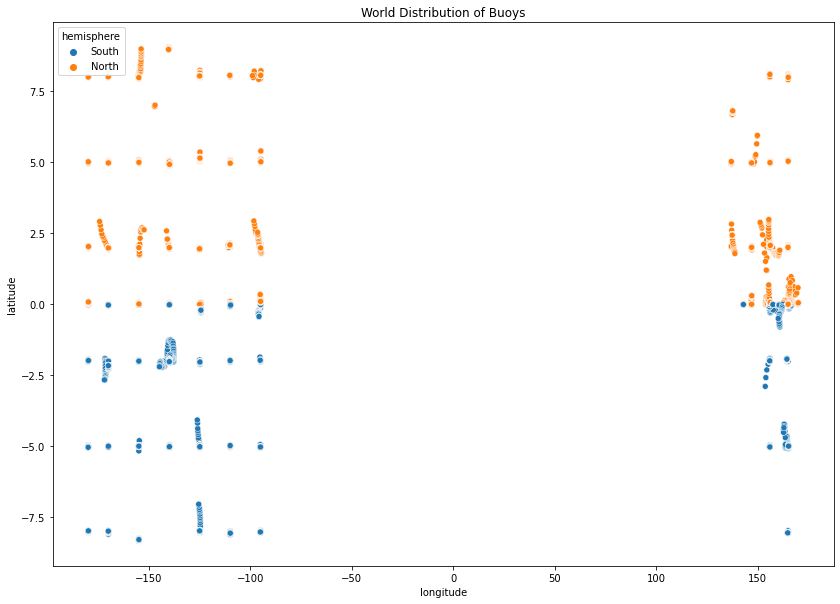

In [39]:
fig = plt.figure(figsize = (14,10))
plt.title('World Distribution of Buoys')
sns.scatterplot(x= 'longitude',y= 'latitude',data=df_drop_humidity,hue='hemisphere')

* Longitude >0 is Indian Ocean
* Longitude <0 is Pacific Ocean
* Indian Ocean has bouys only along certain places. and most of them are in the northern region
* Pacific Ocean bouys are spread across and more evenly distributed
* Pacific Ocean bouys are more compared to Indian Ocean

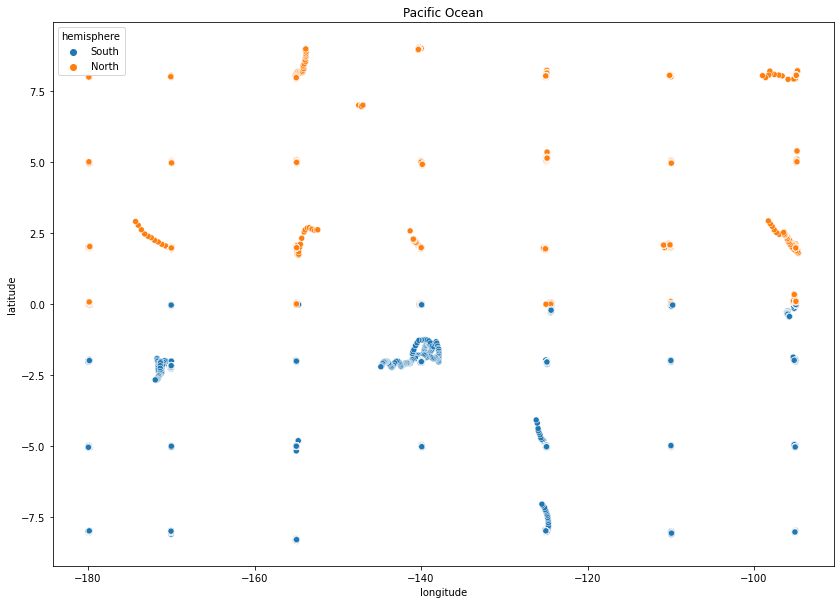

In [40]:
fig1 = plt.figure(figsize = (14,10))
plt.title('Pacific Ocean')
fig1 = sns.scatterplot(x = 'longitude',y = 'latitude',data=
                       df_drop_humidity[df_drop_humidity['ocean']=='Pacific'],hue='hemisphere')



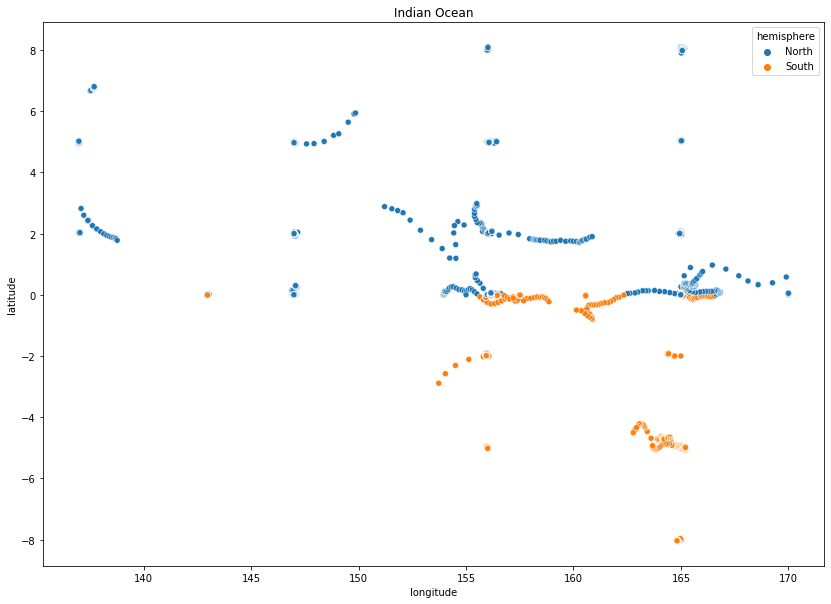

In [41]:
fig2 = plt.figure(figsize = (14,10))
plt.title('Indian Ocean')
fig2 = sns.scatterplot(x = 'longitude',y = 'latitude',data=
                       df_drop_humidity[df_drop_humidity['ocean']!='Pacific'],hue='hemisphere')

Is there any relationship with air temperature and sea surface temperature?

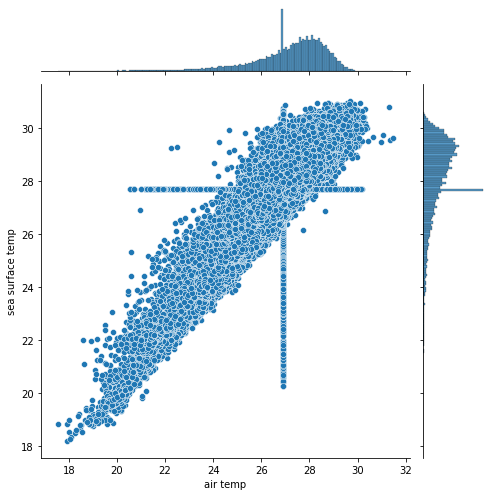

In [42]:
sns.jointplot(x="air temp", y="sea surface temp", data=df_drop_humidity, height=7)


Let's check how the variables are correlated

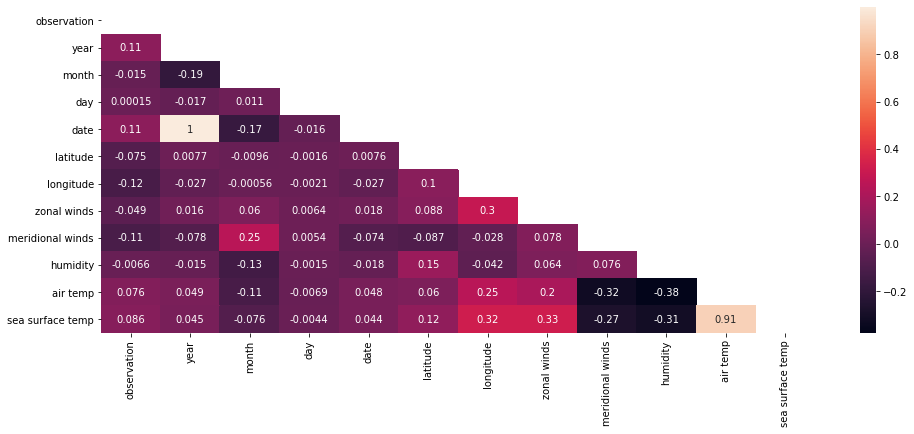

In [43]:
mask = np.triu(np.ones_like(df_drop_humidity.corr()))
plt.figure(figsize=(16, 6))
sns.heatmap(df_drop_humidity.corr(),annot=True, mask = mask);

* We can clearly see that air temperature and sea surface tempreature are highly correlated
* air temperature and medionional winds and humidity are negatively correlated, same goes for sea surface temp
* from the above statement. as the temperature rises, there are less winds and less humidity, same goes for sea surface temp
* add mnore points

Data Quality checks.
* Missing Values - check
* duplicated records
*

In [44]:
df_drop_humidity[df_drop_humidity.duplicated()]

,observation,year,month,day,date,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp,ocean,hemisphere


It is interesting that there are no duplicated values. As we know that the bouys are consistent. There are no new bouys, it's the same bouys that are collecting data for a period of time. So, let's check for duplicated values w.r.t bouys.

As we can notice from the data, there is no bouy ID or any classification to know which bouy is collecting data. Therefore, the data makes sense. its each weather observation.  

We did however, get the position of the bouys, does this mean that with LAT and LON we can classify the bouys and get duplicated records?


In [45]:
df_drop_humidity[df_drop_humidity.duplicated(['latitude', 'longitude'])]

,observation,year,month,day,date,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp,ocean,hemisphere
4060,4061,93,5,10,930510,-0.02,-109.96,-3.4,1.4,84.2,26.95,26.91,Pacific,South
4061,4062,93,5,11,930511,-0.02,-109.96,-3.8,2.2,84.9,26.98,26.78,Pacific,South
4062,4063,93,5,12,930512,-0.02,-109.96,-3.0,1.5,86.9,26.93,26.74,Pacific,South
4063,4064,93,5,13,930513,-0.02,-109.96,-4.5,1.9,87.6,27.01,26.82,Pacific,South
4064,4065,93,5,14,930514,-0.02,-109.96,-5.0,1.3,85.6,26.96,26.68,Pacific,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178074,178075,98,6,10,980610,8.95,-140.33,-6.8,-5.3,81.3,27.52,28.17,Pacific,North
178075,178076,98,6,11,980611,8.96,-140.33,-5.1,-0.4,94.1,26.04,28.14,Pacific,North
178076,178077,98,6,12,980612,8.96,-140.32,-4.3,-3.3,93.2,25.80,27.87,Pacific,North
178077,178078,98,6,13,980613,8.95,-140.34,-6.1,-4.8,81.3,27.17,27.93,Pacific,North


Of course, we see a lot of duplicated values. But we got to keep in mind the year, month, and day columns. As we can clearly see from the above table the year keeps changing. The month might be the same, but with every row the day and date changes.  

What does this signify?  
* The bouys move over time, not in an instant. throught out the years the bouys might stay in the same place and they might move a little. but the data they collect is for over a period of time, and this makes sense. It checks out
* do we need to worry about duplicate values? NO

* Another interesting insight is, The date column in redundant. 
* we alreay have year, month and day column. Therefore we can drop the date column

In [46]:
df_drop_humidity.columns

Index(['observation', 'year', 'month', 'day', 'date', 'latitude', 'longitude',
       'zonal winds', 'meridional winds', 'humidity', 'air temp',
       'sea surface temp', 'ocean', 'hemisphere'],
      dtype='object')

In [47]:
clean_df = df_drop_humidity[['year', 'month', 'day', 'latitude', 'longitude',
       'zonal winds', 'meridional winds', 'humidity', 'air temp',
       'sea surface temp']]
# 'ocean', 'hemisphere']]

In [48]:
clean_df.head()

,year,month,day,latitude,longitude,zonal winds,meridional winds,humidity,air temp,sea surface temp
4059,93,5,9,-0.02,-109.96,-2.1,2.1,81.2,26.80,27.02
4060,93,5,10,-0.02,-109.96,-3.4,1.4,84.2,26.95,26.91
4061,93,5,11,-0.02,-109.96,-3.8,2.2,84.9,26.98,26.78
4062,93,5,12,-0.02,-109.96,-3.0,1.5,86.9,26.93,26.74
4063,93,5,13,-0.02,-109.96,-4.5,1.9,87.6,27.01,26.82


* Rotation of earth to temperature
* lat and lon in the changing weather
* winds w.r.t temp
* temp is main role in ocean 
* temp proportionals to humidity ?
* relation with and every column 

# TODO: PCA or CLUSTERING as part of EDA


Let's remove observation, ocean and hemisphere columns we created so we can reduce the columns using PCA and then perform a clustering analysis

In [49]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

In [50]:
sc = StandardScaler()
df_scaled = sc.fit_transform(clean_df)

KeyboardInterrupt: 

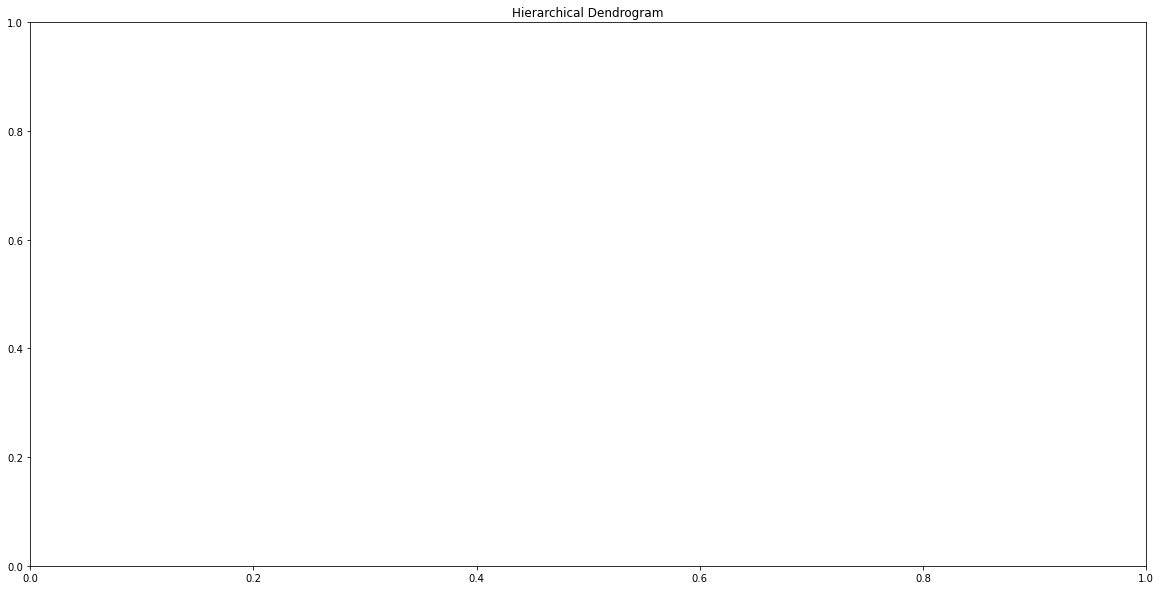

In [51]:
plt.figure(figsize =(20, 10))
plt.title('Hierarchical Dendrogram')
Dendrogram = shc.dendrogram((shc.linkage(df_scaled, method ='complete')))

In [ ]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(df_scaled)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [ ]:
agg_cluster = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'complete')
plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = agg_cluster.fit_predict(X_principal), cmap ='rainbow')
plt.show()


## Predicting weather variables using regression

### Using Decision Tree Regression

We can drop the variables such as observations. Day, Date, Year and month could give us an idea about how the weather is throughout the year

In [ ]:
df_random_for = df_drop_humidity

In [ ]:
df_random_for.head()

In [ ]:
# dataframe for pyspark

data_spark = df_random_for
data_spark.head()

In [ ]:
data_spark = data_spark[['observation', 'year', 'month', 'day', 'date', 'latitude', 'longitude',
       'zonal winds', 'meridional winds', 'humidity', 'air temp',
       'sea surface temp']]

In [ ]:
data_spark.head()

In [ ]:
df_random_for.info()

In [ ]:
df_random_for.ocean[df_random_for.ocean == 'Pacific'] = 1
df_random_for.ocean[df_random_for.ocean == 'Indian'] = 0

In [ ]:
df_random_for.hemisphere[df_random_for.hemisphere == 'South'] = 1
df_random_for.hemisphere[df_random_for.hemisphere == 'North'] = 0

In [ ]:
df_random_for.head()

In [ ]:
df_random_for = df_random_for[['observation', 'year', 'month', 'day', 'date', 'latitude', 'longitude',
       'zonal winds', 'meridional winds', 'humidity', 'air temp',
       'sea surface temp']]

In [ ]:
df_random_for.head()

### Writing functions so that we can predict each weather variable by calling the function

The Aim here is based on research question 1, i.e. can we predict weather throughout the world?

One way to answer this is to predict a target variable, or generate a column with a target variable, that classifies as good weather or bad variable, or to weight each feature to to generate the corresponding weather overall weather. The weighted number gives us an Idea of how the weather is in the current location.  

The most Ideal way is to use a clustering algorithm as this is a unsupervised problem(no target).  

To get a better idea of the weather, I shall take each weather observation as a target variable and predict it using the remaining features. 

In [ ]:
def DTML(data_X, data_y):
    
    """
    The data here is passed because we use each weather attribute as the target variable each time
    """
    # DEFINING X AND Y
    X = data_X
    y_col = data_y
    # TRAIN TEST SPLIT OF THE DATA
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_col,test_size=0.3)
    # CREATING A DT MODEL
    from sklearn.tree import DecisionTreeRegressor
    
    from sklearn.pipeline import Pipeline

    pipe = Pipeline([('tree', DecisionTreeRegressor())], verbose=3)
    pipe.set_params(tree__random_state=42).fit(X_train, y_train)

    #dt_reg = DecisionTreeRegressor(random_state = 42)
    #dt_reg.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    # MODEL EVALUATION
    import sklearn.metrics

    r2_score = sklearn.metrics.r2_score(y_test, y_hat)
    mae = sklearn.metrics.mean_absolute_error(y_test, y_hat)
    mse = sklearn.metrics.mean_squared_error(y_test, y_hat)
    print("Regression Report:")
    print('r2_score: {0}'.format(r2_score))
    print('MAE: {0}'.format(mae))
    print('MSE: {0}'.format(mse))
    print("Actual vs Predicted")
    ac_pr = pd.DataFrame(columns=['Actual','Predicted'])
    ac_pr['Actual'] = y_test
    ac_pr['Predicted'] = y_hat
    return ac_pr
    
    
    

In [ ]:
DTML(df_random_for, df_random_for['sea surface temp'])

In [ ]:
## Regression models with pyspark

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.util import MLUtils
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors

In [ ]:


spark = SparkSession.builder.master("local").appName("DDA").getOrCreate()
spark_df = spark.createDataFrame(data_spark)
spark_df.printSchema()
spark_df.show()
spark_df.columns
spark_df.describe().show()


In [ ]:
def transformData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [ ]:
def SparkDT(data):
    
    # dense vector
    transformed = transformData(spark_df)
    transformed.show(5)
    
    # Dealing with categorical variables
    # Automatically identify categorical features, and index them.
    # We specify maxCategories so features with > 4
    # distinct values are treated as continuous.
    featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures",
                               maxCategories=4).fit(transformed)

    data = featureIndexer.transform(transformed)
    data.show()
    
    
    # VIEWING THE TRANSFORMED DATA
    
    data.show()
    
    # TRAIN TEST SPLITTING THE DATA
    (trainingData, testData) = data.randomSplit([07.,0.3])
    
    # VIEWING THE TRAINING AND THE TEST DATA
    trainingData.show(5)
    testData.show(5)
    
    # FITING THE DECISION TREE MODEL
    import time
    start_time = time.time()


    
    dt = DecisionTreeRegressor(featuresCol = "indexedFeatures")
    
    # CREATING THE PIPELINE ARCHITECTURE
    
    pipeline = Pipeline(stages = [featureIndexer, dt])

    model = pipeline.fit(trainingData)
    
    # MAKING PREDICTIONS
    predictions = model.transform(testData)
    
    # DISPLAY THE PREDICTIONS
    predictions.show(5)
    print(f"Execution time: {time.time() - start_time}")
    
    # MODEL EVALUATION
    
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.evaluation import RegressionEvaluator
    # Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")

    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    
    y_true = predictions.select("label").toPandas()
    y_pred = predictions.select("prediction").toPandas()

    import sklearn.metrics
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
    mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
    print("Regression Report:")
    print('r2_score: {0}'.format(r2_score))
    print('MAE: {0}'.format(mae))
    print('MSE: {0}'.format(mse))
    print("Actual vs Predicted")
    ac_pr = pd.DataFrame(columns=['Actual','Predicted'])
    ac_pr['Actual'] = y_true
    ac_pr['Predicted'] = y_pred
    return ac_pr
    
    
    
    


In [ ]:
SparkDT(data_spark)

In [ ]:
# converting the pandas df to Spark df

#from pyspark.sql import SparkSession

#spark = SparkSession.builder.master("local").appName("DDA").getOrCreate()


In [ ]:
#spark_df = spark.createDataFrame(df_random_for)
#spark_df.printSchema()
#spark_df.show()


In [ ]:
#spark_df.columns

In [ ]:
#spark_df.describe().show()

## Converting data to dence Vector (features and label)

You will find out that all of the machine learning algorithms in Spark are based on the features and label. That is to say, you can play with all of the machine learning algorithms in Spark when you get ready the features and label.



In [ ]:
# Comvert the data to dense vector

#def transformData(data):
 #   return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])



#transformed = transformData(spark_df)
#transformed.show(5)

In [ ]:
# Dealing with categorical variables
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4
# distinct values are treated as continuous.
#featureIndexer = VectorIndexer(inputCol="features", 
 #                              outputCol="indexedFeatures",
  #                             maxCategories=4).fit(transformed)

#data = featureIndexer.transform(transformed)

In [ ]:
#data.show()

In [ ]:
#(trainingData, testData) = data.randomSplit([07.,0.3])

In [ ]:
#trainingData.show(5)
#testData.show(5)

### Fit the decision tree model

In [ ]:
#dt = DecisionTreeRegressor(featuresCol = "indexedFeatures")

### pipeline architectyre

In [ ]:
#pipeline = Pipeline(stages = [featureIndexer, dt])

#model = pipeline.fit(trainingData)

In [ ]:
## making predictions
#predictions = model.transform(testData)

In [ ]:
# displaying the predctions
#predictions.show(5)

### Evaluations

In [ ]:
"""from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)"""

In [ ]:
"""y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
print("Regression Report:")
print('r2_score: {0}'.format(r2_score))
print('MAE: {0}'.format(mae))
print('MSE: {0}'.format(mse))
print("Actual vs Predicted")
ac_pr = pd.DataFrame(columns=['Actual','Predicted'])
ac_pr['Actual'] = y_true
ac_pr['Predicted'] = y_pred
ac_pr
"""

In [ ]:
#model.stages[1].featureImportances